<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston


boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [3]:
# Exploratory data analysis.

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column

boston = pd.concat([y, X], axis=1)
boston.isnull().sum()

MEDV       0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [4]:
boston.dtypes

MEDV       float64
CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object

In [5]:
boston.columns

Index(['MEDV', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [6]:
boston.head()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,21.6,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,34.7,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,33.4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,36.2,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [7]:
boston.shape

(506, 14)

In [8]:
boston.describe()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.532806,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,9.197104,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,5.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,17.025000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,21.200000,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,25.000000,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,50.000000,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


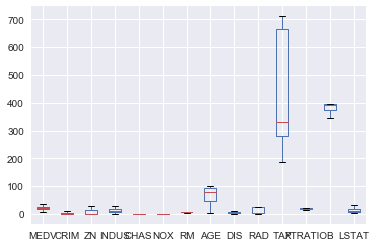

In [9]:
boston.boxplot();

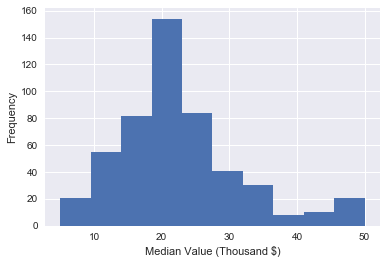

In [10]:
boston.MEDV.plot(kind='hist',bins=10);
plt.xlabel('Median Value (Thousand $)');
plt.ylabel('Frequency');

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

C:\Users\seanlim\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


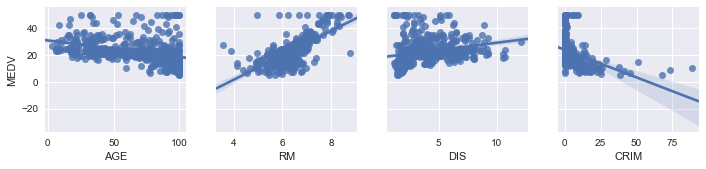

In [11]:
feature_cols = ['AGE', 'RM', 'DIS', 'CRIM']
sns.pairplot(boston, x_vars=feature_cols, y_vars='MEDV', kind='reg');


In [12]:
X = boston[feature_cols]
y = boston.MEDV
print((type(X)))
print((type(X.values)))
print((type(y)))
print((type(y.values)))
print((X.shape))
print((y.shape))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
(506, 4)
(506,)


In [13]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)
lr.predict(X)

array([25.79204131, 22.6767154 , 30.43908692, 29.5268543 , 29.95884986,
       23.78661694, 20.05365229, 18.38108801, 13.56134233, 17.48253888,
       19.89102004, 18.06927789, 21.63626721, 20.46946485, 19.77576565,
       20.17347763, 23.34783305, 19.28838674, 19.39360637, 18.61909102,
       14.64630138, 18.57007769, 19.70719443, 16.27825011, 17.54147107,
       15.62314957, 16.80587804, 18.92511114, 22.06800561, 24.25390622,
       15.87429134, 18.22212634, 18.99264965, 16.0124144 , 18.93507813,
       20.86242579, 20.71599658, 22.19127849, 24.18788423, 28.92839932,
       32.9245096 , 31.79339921, 26.61542091, 26.95858987, 22.79441967,
       20.67379503, 21.55266397, 18.36435751, 12.26075651, 16.75770267,
       20.6456764 , 20.31603999, 27.29143207, 23.13370981, 19.52361265,
       31.81702566, 23.23964285, 26.91545942, 22.86810929, 20.13230827,
       16.69452195, 16.33497342, 22.31708104, 26.44006466, 26.86911016,
       25.96037899, 20.70503845, 22.39343763, 18.69585861, 21.38

In [14]:
print(lr.intercept_)
print(lr.coef_)
list(zip(feature_cols, lr.coef_)) #list all the coef

-18.318557274394283
[-0.09041879  8.05355038 -0.71998328 -0.23079706]


[('AGE', -0.09041878723747243),
 ('RM', 8.053550381571936),
 ('DIS', -0.7199832795283917),
 ('CRIM', -0.23079705521998373)]

Interpreting the coefficients:

Holding all other features fixed, a 1-unit increase in AGE is associated with a $90 decrease in median value

Holding all other features fixed, a 1-unit increase in RM is associated with a $8,054 increase in median value

Holding all other features fixed, a 1-unit increase in DIS is associated with a $720 decrease in median value 

Holding all other features fixed, a 1-unit increase in CRIM is associated with a $231 decrease in median value


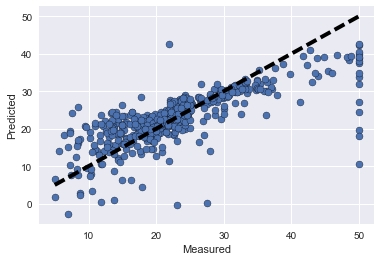

In [15]:
# Plotting my predictions using AGE, RM, DIS, CRIM

fig, ax = plt.subplots()
ax.scatter(y,lr.predict(X) , edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [16]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Define a function that accepts a list of features and returns testing RMSE.
def train_test_rmse(df, feature_cols):
    X = df[feature_cols]
    y = df.MEDV
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=99)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    y_null = np.zeros_like(y_test, dtype=float)
    y_null.fill(y_test.mean())

    
    print(metrics.mean_squared_error(y_train, lr.predict(X_train))) #Training Error
    print(metrics.mean_squared_error(y_test, y_pred)) #Testing Error
    print(metrics.mean_squared_error(y_test, y_null)) #Null Baseline

train_test_rmse(boston, feature_cols)

#The 70/30 split performed better than the baseline



35.94654856077583
36.15000106052951
84.66701480263157


In [17]:
from sklearn.model_selection import train_test_split

# Define a function that accepts a list of features and returns testing RMSE.
#90/10 Split
def train_test_rmse(df, feature_cols):
    X = df[feature_cols]
    y = df.MEDV
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=99)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    y_null = np.zeros_like(y_test, dtype=float)
    y_null.fill(y_test.mean())

    
    print(metrics.mean_squared_error(y_train, lr.predict(X_train))) #Training error
    print(metrics.mean_squared_error(y_test, y_pred)) #Testing error
    print(metrics.mean_squared_error(y_test, y_null)) #Null Baseline

train_test_rmse(boston, feature_cols)

#The 90/10 split performed better than both the 70/30 split and the baseline

36.97836366531981
27.174835149395594
70.37331795463282


### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [18]:
from sklearn import model_selection
kf = model_selection.KFold(n_splits=5, shuffle=True)
mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 34.68413516765925
R2: 0.573155502766876

Model 2
MSE: 55.45541541404833
R2: 0.5720079649936767

Model 3
MSE: 32.94329418283846
R2: 0.5735847666798599

Model 4
MSE: 32.561673603629174
R2: 0.5732583139799656

Model 5
MSE: 27.874985502994978
R2: 0.5739058980193168

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 36.70390077423404
Mean of R2 for all folds: 0.5731824892879389


In [19]:
from sklearn.model_selection import cross_val_score

# Note the results will vary each run since we take a different
#   subset of the data each time (since shuffle=True)
kf = model_selection.KFold(n_splits=5, shuffle=True)

print(np.mean(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error')))
print(np.mean(cross_val_score(lr, X, y, cv=kf)))

36.60794241598013
0.567228543767473


In [20]:
from sklearn import model_selection
kf = model_selection.KFold(n_splits=10, shuffle=True)
mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 30.065869550698945
R2: 0.5738648061337557

Model 2
MSE: 33.22484652078188
R2: 0.5739719216907624

Model 3
MSE: 33.9326119191947
R2: 0.5741266880373246

Model 4
MSE: 27.100944608246294
R2: 0.5741421944540619

Model 5
MSE: 48.35956930831953
R2: 0.5736760632190554

Model 6
MSE: 41.98716489040819
R2: 0.5738420046487408

Model 7
MSE: 63.44940271083806
R2: 0.573783311972001

Model 8
MSE: 19.753049021650337
R2: 0.574110850878757

Model 9
MSE: 45.33089955934348
R2: 0.5727210595823025

Model 10
MSE: 23.538410913426752
R2: 0.5730628870909149

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 36.67427690029082
Mean of R2 for all folds: 0.5737301787707676


In [21]:
from sklearn.model_selection import cross_val_score

kf = model_selection.KFold(n_splits=10, shuffle=True)

print(np.mean(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error')))
print(np.mean(cross_val_score(lr, X, y, cv=kf)))

37.09695676971228
0.5360695950217741


It seems that the more folds you have the better the average RMSE becomes, but the individual model RMSEs vary a lot more and it becomes more difficult to single out a model.


# KNN Practice

In [22]:
# Read the iris data into a DataFrame
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [23]:
iris.head()

# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

In [24]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

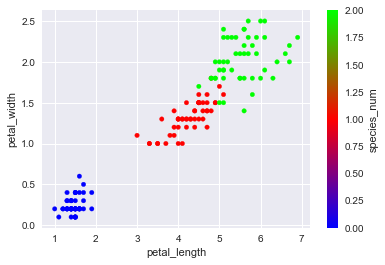

In [25]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'
iris['species_num'] = iris.species.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})
# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
iris.plot(kind='scatter', x='petal_length', y='petal_width', c='species_num', colormap='brg');
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES

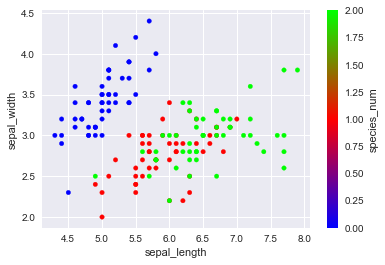

In [26]:
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES
iris.plot(kind='scatter', x='sepal_length', y='sepal_width', c='species_num', colormap='brg');

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [27]:
feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = iris[feature_cols]

### Create your target vector "y"
This will be the species type.

In [28]:
y = iris.species

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)


### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [31]:
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

0.9210526315789473


### Create a Model With Five Neighbors. Did it Improve?

In [32]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))
# No improvement - stayed the same

0.9210526315789473


### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [33]:
scores = []
for k in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X,y)
    pred = knn.predict(X)
    score = float(sum(pred == y)) / len(y)
    scores.append([k, score])


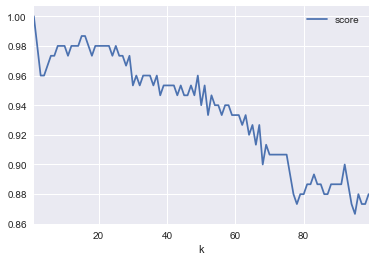

In [34]:
data = pd.DataFrame(scores,columns=['k','score'])
data.plot.line(x='k',y='score');

In [35]:
# Calculate TRAINING ERROR and TESTING ERROR for K=1 through 100.

k_range = list(range(1, 101))
training_error = []
testing_error = []

# Find test accuracy for all values of K between 1 and 100 (inclusive).
for k in k_range:

    # Instantiate the model with the current K value.
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Calculate training error (error = 1 - accuracy).
    y_pred_class = knn.predict(X)
    training_accuracy = metrics.accuracy_score(y, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    # Calculate testing error.
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)

In [36]:
# Allow plots to appear in the notebook.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [37]:
# Create a DataFrame of K, training error, and testing error.
column_dict = {'K': k_range, 'training error':training_error, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)
df.head()

,training error,testing error
K,,
100,0.220000,0.236842
99,0.220000,0.236842
98,0.220000,0.236842
97,0.213333,0.236842
96,0.213333,0.236842


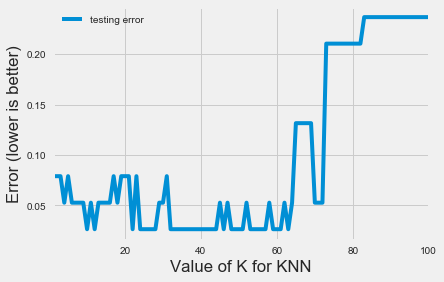

In [38]:
# Plot the relationship between K (HIGH TO LOW) and TESTING ERROR.
df.plot(y='testing error');
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');

In [39]:
# Find the minimum testing error and the associated K value.
df.sort_values('testing error').head()

,training error,testing error
K,,
51,0.073333,0.026316
33,0.040000,0.026316
34,0.040000,0.026316
63,0.086667,0.026316
61,0.086667,0.026316


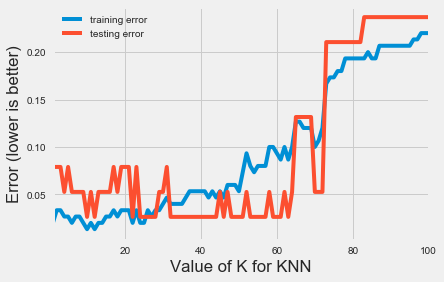

In [40]:
# Plot the relationship between K (HIGH TO LOW) and both TRAINING ERROR and TESTING ERROR.
df.plot();
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [42]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

AttributeError: 'DataFrame' object has no attribute 'feature_names'

In [ ]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

In [ ]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X);

In [ ]:
# Check out Pearson scores


## Demo: Patsy

In [ ]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [ ]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [ ]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))